In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install datasets
import datasets

from tensorflow.keras import Sequential, layers, losses, optimizers, callbacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'archive (12).zip' is the file containing the data for this notebook.

In [ ]:
import zipfile
import os

home_dir = '/content/'
file = '/content/archive (12).zip'

ref = zipfile.ZipFile(file)
ref.extractall()
ref.close()

for file in os.listdir(home_dir):
  print(file)

.config
PFE_2006-01-01_to_2018-01-01.csv
PG_2006-01-01_to_2018-01-01.csv
CSCO_2006-01-01_to_2018-01-01.csv
all_stocks_2017-01-01_to_2018-01-01.csv
all_stocks_2006-01-01_to_2018-01-01.csv
AXP_2006-01-01_to_2018-01-01.csv
JNJ_2006-01-01_to_2018-01-01.csv
UNH_2006-01-01_to_2018-01-01.csv
GS_2006-01-01_to_2018-01-01.csv
GE_2006-01-01_to_2018-01-01.csv
IBM_2006-01-01_to_2018-01-01.csv
INTC_2006-01-01_to_2018-01-01.csv
UTX_2006-01-01_to_2018-01-01.csv
GOOGL_2006-01-01_to_2018-01-01.csv
MRK_2006-01-01_to_2018-01-01.csv
CVX_2006-01-01_to_2018-01-01.csv
AAPL_2006-01-01_to_2018-01-01.csv
VZ_2006-01-01_to_2018-01-01.csv
JPM_2006-01-01_to_2018-01-01.csv
DIS_2006-01-01_to_2018-01-01.csv
WMT_2006-01-01_to_2018-01-01.csv
AABA_2006-01-01_to_2018-01-01.csv
AMZN_2006-01-01_to_2018-01-01.csv
MMM_2006-01-01_to_2018-01-01.csv
BA_2006-01-01_to_2018-01-01.csv
NKE_2006-01-01_to_2018-01-01.csv
MSFT_2006-01-01_to_2018-01-01.csv
archive (12).zip
XOM_2006-01-01_to_2018-01-01.csv
CAT_2006-01-01_to_2018-01-01.csv
M

Let's choose the google stock prices csv for this one.

In [ ]:
df = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


We are going to start off by only predicting the *closing price* before making things slightly more complicated.

In [ ]:
# Drop name column
df = df.drop('Name', axis=1)

In [ ]:
# Make date column the index and drop date
df.index = pd.to_datetime(df['Date'])

In [ ]:
df = df.drop('Date', axis=1)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450
2006-01-04,222.17,224.70,220.09,222.84,15292353
2006-01-05,223.22,226.00,220.97,225.85,10815661
2006-01-06,228.66,235.49,226.85,233.06,17759521
2006-01-09,233.44,236.94,230.70,233.68,12795837


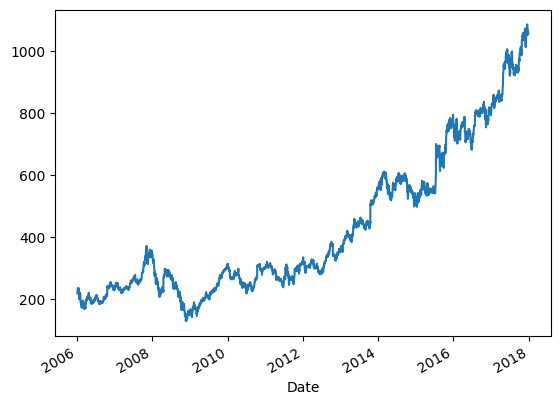

In [ ]:
df['Close'].plot();

In [ ]:
df.Close.isna().value_counts()

False    3019
Name: Close, dtype: int64

In [ ]:
len(df)

3019

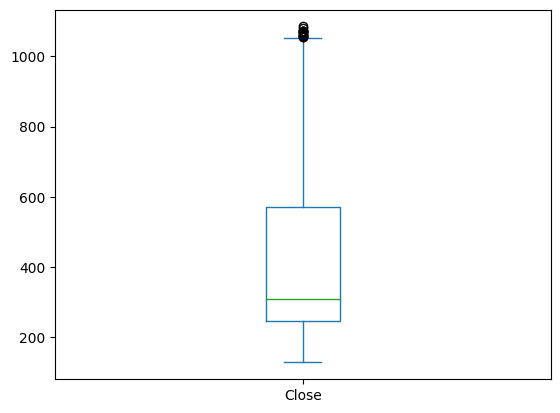

In [ ]:
df.Close.plot.box();

No missing values. We can go ahead and start splitting our data and then move on to windowing and labelling it.

In [ ]:
split = int(0.8 * len(df))

In [ ]:
# Derive mean and standard deviation for dataset
close_mean = np.mean(df.Close)
close_std = np.std(df.Close)

close_mean, close_std

(428.044001324942, 236.30409250883486)

In [ ]:
def preprocess(data):
  preprocessed_values = []
  mean = np.mean(data)
  std = np.std(data)

  for value in data:
    value = (value - mean) / std
    preprocessed_values.append(value)
  
  preprocessed_values = np.array(preprocessed_values)
  cache = {'preprocessed_values': preprocessed_values,
           'mean': mean,
           'std': std}
  
  return cache

def post_process(cache):
  return (cache['preprocessed_values'] * cache['std']) + cache['mean']

In [ ]:
# Test functions
data = [1, 2, 3, 4, 5, 6, 7]

test_cache = preprocess(data)

returned_data = post_process(test_cache)
returned_data

array([1., 2., 3., 4., 5., 6., 7.])

Now let's make a function for turning the data into windows and labels. We'll train with a few different window sizes to see how the model performs.

In [ ]:
WINDOW = 7

def make_windows(data, window=WINDOW):
  
  sequences = []
  labels = []

  for i in range(len(data) - window):
    row = [price for price in data[i: i + window]]
    sequences.append(row)
    label = data[i + window]
    labels.append(label)

  return np.array(sequences), np.array(labels)

In [ ]:
# Split data
train_data = df.Close[:split]
val_data = df.Close[split:]

In [ ]:
# Preprocess input data
train_cache = preprocess(train_data)
val_cache = preprocess(val_data)

In [ ]:
X_train, y_train = make_windows(train_cache['preprocessed_values'])
X_val, y_val = make_windows(val_cache['preprocessed_values'])

In [ ]:
print(X_train[:6], y_train[:6])

[[-0.85300924 -0.81425802 -0.79097634 -0.73520861 -0.73041305 -0.71935232
  -0.71208163]
 [-0.81425802 -0.79097634 -0.73520861 -0.73041305 -0.71935232 -0.71208163
  -0.74302074]
 [-0.79097634 -0.73520861 -0.73041305 -0.71935232 -0.71208163 -0.74302074
  -0.73288818]
 [-0.73520861 -0.73041305 -0.71935232 -0.71208163 -0.74302074 -0.73288818
  -0.72956223]
 [-0.73041305 -0.71935232 -0.71208163 -0.74302074 -0.73288818 -0.72956223
  -0.81549558]
 [-0.71935232 -0.71208163 -0.74302074 -0.73288818 -0.72956223 -0.81549558
  -0.84829103]] [-0.74302074 -0.73288818 -0.72956223 -0.81549558 -0.84829103 -0.99146173]


In [ ]:
print(X_val[:6], y_val[:6])

[[-1.4596388  -1.21859205 -1.20820823 -1.25222855 -1.22684586 -1.18477806
  -1.2325259 ]
 [-1.21859205 -1.20820823 -1.25222855 -1.22684586 -1.18477806 -1.2325259
  -1.18539931]
 [-1.20820823 -1.25222855 -1.22684586 -1.18477806 -1.2325259  -1.18539931
  -1.31462025]
 [-1.25222855 -1.22684586 -1.18477806 -1.2325259  -1.18539931 -1.31462025
  -1.62924129]
 [-1.22684586 -1.18477806 -1.2325259  -1.18539931 -1.31462025 -1.62924129
  -1.85928296]
 [-1.18477806 -1.2325259  -1.18539931 -1.31462025 -1.62924129 -1.85928296
  -1.90933832]] [-1.18539931 -1.31462025 -1.62924129 -1.85928296 -1.90933832 -1.48981402]


In [ ]:
X_train.shape

(2408, 7)

In [ ]:
# Build model
model1 = Sequential([
    layers.Input(shape=(7, 1)),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.LSTM(32, recurrent_dropout=0.2),
    layers.Dense(16, 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, 'linear')
], name='lstm')

model1.compile(loss=losses.Huber(),
               optimizer='adam',
               metrics=['mae', 'mse'])

model1.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 7, 64)            8704      
 nal)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 21,665
Trainable params: 21,665
Non-trainable params: 0
__________________________________________________________

In [ ]:
model1.fit(X_train, y_train, epochs=100,
           validation_data=(X_val, y_val))

Epoch 1/100
76/76 [==============================] - 6s 20ms/step - loss: 0.1192 - mae: 0.3329 - mse: 0.2569 - val_loss: 0.0182 - val_mae: 0.1456 - val_mse: 0.0364
Epoch 2/100
76/76 [==============================] - 1s 13ms/step - loss: 0.0287 - mae: 0.1643 - mse: 0.0575 - val_loss: 0.0113 - val_mae: 0.1145 - val_mse: 0.0226
Epoch 3/100
76/76 [==============================] - 1s 18ms/step - loss: 0.0242 - mae: 0.1445 - mse: 0.0491 - val_loss: 0.0110 - val_mae: 0.1149 - val_mse: 0.0221
Epoch 4/100
76/76 [==============================] - 1s 11ms/step - loss: 0.0260 - mae: 0.1493 - mse: 0.0537 - val_loss: 0.0110 - val_mae: 0.1124 - val_mse: 0.0221
Epoch 5/100
76/76 [==============================] - 1s 10ms/step - loss: 0.0242 - mae: 0.1471 - mse: 0.0487 - val_loss: 0.0101 - val_mae: 0.1065 - val_mse: 0.0202
Epoch 6/100
76/76 [==============================] - 1s 9ms/step - loss: 0.0211 - mae: 0.1402 - mse: 0.0423 - val_loss: 0.0109 - val_mae: 0.1149 - val_mse: 0.0219
Epoch 7/100
76/76

19/19 [==============================] - 1s 3ms/step


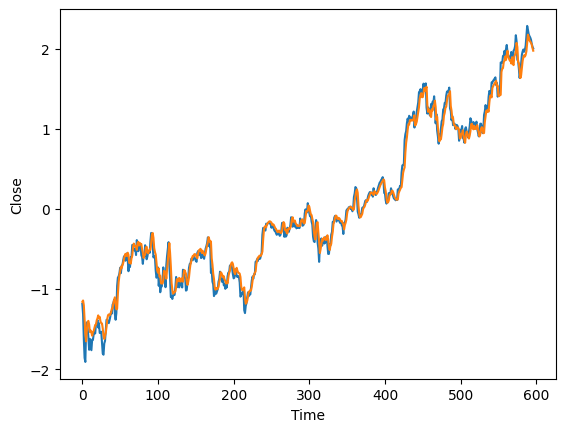

In [ ]:
preds = model1.predict(X_val)

plt.plot(y_val)
plt.plot(preds)
plt.xlabel("Time")
plt.ylabel("Close")
plt.show();

In [ ]:
val_post = post_process(val_cache)
val_post.shape

(604,)

In [ ]:
val_data.shape

(604,)

In [ ]:
# Post process preds
preds = (preds * val_cache['std']) + val_cache['mean']

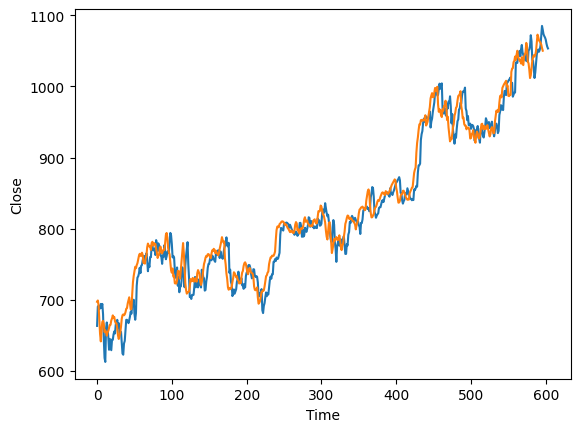

In [ ]:
plt.plot(val_post)
plt.plot(preds)
plt.xlabel("Time")
plt.ylabel("Close")
plt.show();

For future reference, let's functionize the post-processing, predicting, and plotting of the data before moving on to some multivariate modeling.

In [ ]:
def make_and_plot_preds(model, data, cache):
  preds = model.predict(data)
  post_data = post_process(cache)

  post_preds = (preds * cache['std']) + cache['mean']
  
  plt.plot(val_post)
  plt.plot(post_preds)
  plt.xlabel("Time")
  plt.ylabel(data.name)
  plt.show();

## ***Multivariate Time Series***

In [ ]:
# Remind ourselves of the original df
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450
2006-01-04,222.17,224.70,220.09,222.84,15292353
2006-01-05,223.22,226.00,220.97,225.85,10815661
2006-01-06,228.66,235.49,226.85,233.06,17759521
2006-01-09,233.44,236.94,230.70,233.68,12795837


Let's use all but the `Volume` column to predict the Close prices now.

In [ ]:
# Drop volume
close_multi_df = df.drop('Volume', axis=1)
close_multi_df.head(8)

,Open,High,Low,Close
Date,,,,
2006-01-03,211.47,218.05,209.32,217.83
2006-01-04,222.17,224.70,220.09,222.84
2006-01-05,223.22,226.00,220.97,225.85
2006-01-06,228.66,235.49,226.85,233.06
2006-01-09,233.44,236.94,230.70,233.68
2006-01-10,232.44,235.36,231.25,235.11
2006-01-11,235.87,237.79,234.82,236.05
2006-01-12,237.10,237.73,230.98,232.05


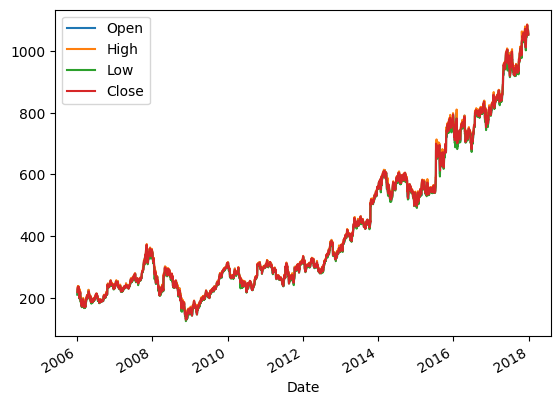

In [ ]:
close_multi_df.plot();

In [ ]:
def preprocess(data):
  mean = np.mean(data)
  std = np.std(data)
  processed_data = (data - mean) / std
  return data, processed_data

In [ ]:
split = int(0.8 * len(close_multi_df))

multi_train_data = close_multi_df[:split]
multi_val_data = close_multi_df[split:]

In [ ]:
# Let's update our windowing function
WINDOW = 7

def multivar_windows(data, window=WINDOW):

  data = np.array(data)
  sequences = []
  labels = []

  for i in range(len(data) - window):
    row = [r for r in data[i: i + window]]
    sequences.append(np.array(row))
    label = data[i + window][-1]
    labels.append(np.array(label))

  return np.array(sequences), np.array(labels)

In [ ]:
X_train, y_train = multivar_windows(multi_train_data)
X_val, y_val = multivar_windows(multi_val_data)

In [ ]:
X_train[:5], y_train[:5]

(array([[[211.47, 218.05, 209.32, 217.83],
         [222.17, 224.7 , 220.09, 222.84],
         [223.22, 226.  , 220.97, 225.85],
         [228.66, 235.49, 226.85, 233.06],
         [233.44, 236.94, 230.7 , 233.68],
         [232.44, 235.36, 231.25, 235.11],
         [235.87, 237.79, 234.82, 236.05]],
 
        [[222.17, 224.7 , 220.09, 222.84],
         [223.22, 226.  , 220.97, 225.85],
         [228.66, 235.49, 226.85, 233.06],
         [233.44, 236.94, 230.7 , 233.68],
         [232.44, 235.36, 231.25, 235.11],
         [235.87, 237.79, 234.82, 236.05],
         [237.1 , 237.73, 230.98, 232.05]],
 
        [[223.22, 226.  , 220.97, 225.85],
         [228.66, 235.49, 226.85, 233.06],
         [233.44, 236.94, 230.7 , 233.68],
         [232.44, 235.36, 231.25, 235.11],
         [235.87, 237.79, 234.82, 236.05],
         [237.1 , 237.73, 230.98, 232.05],
         [232.39, 233.68, 231.04, 233.36]],
 
        [[228.66, 235.49, 226.85, 233.06],
         [233.44, 236.94, 230.7 , 233.68],
  

In [ ]:
multivar_lstm = Sequential([
    layers.Input((7, 4)),
    layers.LSTM(64),
    layers.Dense(32),
    layers.Dropout(0.3),
    layers.Dense(4, 'linear')
], name='multivar_lstm')

multivar_lstm.compile(loss = losses.Huber(),
                      optimizer='adam',
                      metrics=['mae', 'mse'])

In [ ]:
history = multivar_lstm.fit(X_train, y_train, epochs=100,
                            validation_data=(X_val, y_val))

Epoch 1/100
76/76 [==============================] - 3s 11ms/step - loss: 323.5705 - mae: 324.0705 - mse: 121737.1562 - val_loss: 818.0932 - val_mae: 818.5932 - val_mse: 682703.4375
Epoch 2/100
76/76 [==============================] - 0s 5ms/step - loss: 303.4001 - mae: 303.9001 - mse: 109183.4062 - val_loss: 785.4991 - val_mae: 785.9991 - val_mse: 630415.2500
Epoch 3/100
76/76 [==============================] - 0s 5ms/step - loss: 257.7092 - mae: 258.2092 - mse: 83955.6172 - val_loss: 725.6003 - val_mae: 726.1003 - val_mse: 539879.6875
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 184.1131 - mae: 184.6127 - mse: 51461.9375 - val_loss: 638.0983 - val_mae: 638.5983 - val_mse: 420501.3125
Epoch 5/100
76/76 [==============================] - 0s 4ms/step - loss: 117.6820 - mae: 118.1805 - mse: 27673.8027 - val_loss: 571.1108 - val_mae: 571.6108 - val_mse: 339146.2500
Epoch 6/100
76/76 [==============================] - 0s 5ms/step - loss: 101.4966 - mae: 101.9951

In [ ]:
open_mean = np.mean(X_train[:, :, 0])
open_std = np.std(X_train[:, :, 0])

high_mean = np.mean(X_train[:, :, 1])
high_std = np.std(X_train[:, :, 1])

low_mean = np.mean(X_train[:, :, 2])
low_std = np.std(X_train[:, :, 2])

close_mean = np.mean(X_train[:, :, 3])
close_std = np.std(X_train[:, :, 3])

# Create preprocessing functions
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - open_mean) / open_std
  X[:, :, 1] = (X[:, :, 1] - high_mean) / high_std
  X[:, :, 2] = (X[:, :, 2] - low_mean) / low_std
  X[:, :, 3] = (X[:, :, 3] - close_mean) / close_std
  return X

def preprocess_outputs(y):
  y = (y - close_mean) / close_std
  return y

In [ ]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)

y_train = preprocess_outputs(y_train)
y_val = preprocess_outputs(y_val)

In [ ]:
X_train.shape, X_val.shape

((2408, 7, 4), (597, 7, 4))

In [ ]:
y_train[:10]

array([-0.74312009, -0.73294025, -0.72959878, -0.81593315, -0.84888164,
       -0.99272046, -0.88369514, -0.82323777, -0.86224754, -0.85735189])

In [ ]:
multivar_lstm2 = Sequential([
    layers.Input((7, 4)),
    layers.LSTM(64),
    layers.Dense(32),
    layers.Dropout(0.3),
    layers.Dense(4, 'linear')
], name='multivar_lstm')

multivar_lstm2.compile(loss = losses.Huber(),
                      optimizer='adam',
                      metrics=['mae', 'mse'])

history2 = multivar_lstm2.fit(X_train, y_train, epochs=100,
                            validation_data=(X_val, y_val))

Epoch 1/100
76/76 [==============================] - 3s 11ms/step - loss: 0.0846 - mae: 0.2711 - mse: 0.1838 - val_loss: 0.7713 - val_mae: 1.2275 - val_mse: 2.0212
Epoch 2/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0237 - mae: 0.1483 - mse: 0.0475 - val_loss: 0.6533 - val_mae: 1.1048 - val_mse: 1.6182
Epoch 3/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0202 - mae: 0.1371 - mse: 0.0406 - val_loss: 0.4240 - val_mae: 0.8189 - val_mse: 0.9736
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0177 - mae: 0.1291 - mse: 0.0354 - val_loss: 0.3961 - val_mae: 0.7995 - val_mse: 0.8822
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0172 - mae: 0.1264 - mse: 0.0344 - val_loss: 0.3079 - val_mae: 0.6757 - val_mse: 0.6633
Epoch 6/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0160 - mae: 0.1215 - mse: 0.0321 - val_loss: 0.2486 - val_mae: 0.5942 - val_mse: 0.5219
Epoch 7/100
76/76 [==

In [ ]:
y_val = (y_val * close_std) + close_mean

19/19 [==============================] - 0s 3ms/step


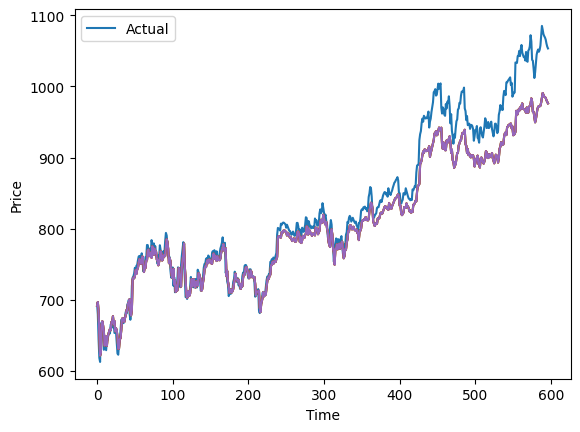

In [ ]:
# Post process, predict, and plot
preds = multivar_lstm2.predict(X_val)
preds = (preds * close_std) + close_mean

plt.plot(y_val)
plt.plot(preds)
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(["Actual"])
plt.show();